In [1]:
import pandas as pd
import numpy as np


In [2]:
from typing import cast
from tesi.database.di import get_session_maker
from tesi.zappai.di import (
    get_cds_api,
    get_climate_generative_model_repository,
    get_future_climate_data_repository,
    get_location_repository,
    get_past_climate_data_repository,
)
from tesi.zappai.repositories.dtos import (
    ClimateDataDTO,
    FutureClimateDataDTO,
    LocationDTO,
)
from tesi.zappai.utils import common


session_maker = get_session_maker()
cds_api = get_cds_api()
location_repository = get_location_repository(session_maker=session_maker)
past_climate_data_repository = get_past_climate_data_repository(
    session_maker=session_maker,
    cds_api=cds_api,
    location_repository=location_repository,
)
future_climate_data_repository = get_future_climate_data_repository(
    session_maker=session_maker, cds_api=cds_api
)
climate_generative_model_repository = get_climate_generative_model_repository(
    session_maker=session_maker,
    location_repository=location_repository,
    past_climate_data_repository=past_climate_data_repository,
    future_climate_data_repository=future_climate_data_repository,
)

location = await location_repository.get_location_by_country_and_name(
    country=common.EXAMPLE_LOCATION_COUNTRY, name=common.EXAMPLE_LOCATION_NAME
)
if location is None:
    location = await location_repository.create_location(
        country=common.EXAMPLE_LOCATION_COUNTRY,
        name=common.EXAMPLE_LOCATION_NAME,
        longitude=common.EXAMPLE_LONGITUDE,
        latitude=common.EXAMPLE_LATITUDE,
    )

2024-06-19 02:06:42.428850: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 02:06:42.431479: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 02:06:42.463719: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 02:06:43.137410: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
location = cast(LocationDTO, location)

await climate_generative_model_repository.delete_climate_generative_model(
    location_id=location.id
)
climate_generative_model = (
    await climate_generative_model_repository.create_model_for_location(location.id)
)
model = climate_generative_model.model
x_scaler = climate_generative_model.x_scaler
y_scaler = climate_generative_model.y_scaler

Epoch 1/50


2024-06-19 02:06:43.985138: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-19 02:06:43.985673: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0685 - root_mean_squared_error: 1.0332 - val_loss: 0.9405 - val_root_mean_squared_error: 0.9698
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8469 - root_mean_squared_error: 0.9198 - val_loss: 0.7431 - val_root_mean_squared_error: 0.8620
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6621 - root_mean_squared_error: 0.8129 - val_loss: 0.5726 - val_root_mean_squared_error: 0.7567
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5499 - root_mean_squared_error: 0.7406 - val_loss: 0.4236 - val_root_mean_squared_error: 0.6509
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3647 - root_mean_squared_error: 0.6034 - val_loss: 0.3020 - val_root_mean_squared_error: 0.5496
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2585 - root_mean_squared_error: 0.5082 - val_loss: 0.1994 - val_root_mean_squared_error: 0.4465
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1694 - root_mea

In [4]:
from tesi.zappai.repositories.climate_generative_model_repository import (
    ClimateGenerativeModelRepository,
    FEATURES,
    TARGET,
    CMIP5_VARIABLES,
    SEQ_LENGTH,
    add_sin_cos_year
)


df_test = ClimateDataDTO.from_list_to_dataframe(
    await past_climate_data_repository.get_past_climate_data(
        location_id=location.id,
        year_from=climate_generative_model.test_start_year,
        month_from=climate_generative_model.test_start_month,
        year_to=climate_generative_model.test_end_year,
        month_to=climate_generative_model.test_end_month,
    )
)

df_test = add_sin_cos_year(df_test)

In [5]:
x_df_test = df_test[FEATURES]
x_df_test

soil_temperature_level_3  sin_year      cos_year  \
year month                                                     
2011 10                   293.741419 -1.000000 -1.836970e-16   
     11                   289.806455 -0.866025  5.000000e-01   
     12                   286.558917 -0.500000  8.660254e-01   
2012 1                    283.667371  0.000000  1.000000e+00   
     2                    282.454511  0.500000  8.660254e-01   
...                              ...       ...           ...   
2024 1                    285.878260  0.000000  1.000000e+00   
     2                    285.261142  0.500000  8.660254e-01   
     3                    286.256922  0.866025  5.000000e-01   
     4                    288.858824  1.000000  6.123234e-17   
     5                    291.249895  0.866025 -5.000000e-01   

            10m_u_component_of_wind  10m_v_component_of_wind  2m_temperature  \
year month                                                                     
2011 10                    0.461430                -1.141662      290.862260   
     11                   -0.181396                -0.330990      287.150551   
     12                    1.268430                -0.125131      284.456450   
2012 1                     1.721778                -1.836420      281.515102   
     2                     1.043455                -1.545993      280.743743   
...                             ...                      ...             ...   
2024 1                     1.464902                -0.637662      284.485659   
     2                     0.564335                 0.520767      285.610095   
     3                     0.811452                 0.963794      286.796737   
     4                     0.760184                 0.400504      289.575987   
     5                     0.367084                 0.532176      292.594924   

            evaporation  total_precipitation  surface_pressure  \
year month                                                       
2011 10       -0.003017             0.001613     100051.252778   
     11       -0.001732             0.003173     100361.739811   
     12       -0.001938             0.001412     100000.368555   
2012 1        -0.002350             0.001162     100035.258620   
     2        -0.002333             0.006076      99683.801669   
...                 ...                  ...               ...   
2024 1        -0.001723             0.001416     100015.995353   
     2        -0.001290             0.002229      99883.250332   
     3        -0.001775             0.000971      99534.306838   
     4        -0.002236             0.001208      99752.446554   
     5        -0.002159             0.001128      99560.803809   

            surface_solar_radiation_downwards  \
year month                                      
2011 10                          1.192052e+07   
     11                          7.867499e+06   
     12                          6.771313e+06   
2012 1                           8.295657e+06   
     2                           8.984526e+06   
...                                       ...   
2024 1                           7.378288e+06   
     2                           1.103211e+07   
     3                           1.623242e+07   
     4                           2.111158e+07   
     5                           2.225734e+07   

            surface_thermal_radiation_downwards  
year month                                       
2011 10                            2.856999e+07  
     11                            2.756182e+07  
     12                            2.541200e+07  
2012 1                             2.357119e+07  
     2                             2.516410e+07  
...                                         ...  
2024 1                             2.548385e+07  
     2                             2.576133e+07  
     3                             2.616479e+07  
     4                             2.717887e+07  
     5                             2.9696

In [6]:
y_df_test = df_test[TARGET]
y_df_test

soil_temperature_level_3
year month                          
2011 10                   293.741419
     11                   289.806455
     12                   286.558917
2012 1                    283.667371
     2                    282.454511
...                              ...
2024 1                    285.878260
     2                    285.261142
     3                    286.256922
     4                    288.858824
     5                    291.249895

[152 rows x 1 columns]

In [7]:
from typing import cast

from tesi.zappai.repositories.climate_generative_model_repository import ClimateGenerativeModelRepository

print(y_df_test.columns)

x_test_scaled = cast(np.ndarray, x_scaler.transform(x_df_test.to_numpy()))
y_test_scaled = cast(np.ndarray, y_scaler.transform(y_df_test.to_numpy()))

x_test_formatted, y_test_formatted = ClimateGenerativeModelRepository.format_data(x=x_test_scaled, y=y_test_scaled)
x_test_formatted.shape, y_test_formatted.shape

Index(['soil_temperature_level_3'], dtype='object')


((140, 12, 11), (140, 1))

In [8]:
predictions = model.predict(x_test_formatted)
inverse_scaled_predictions = cast(np.ndarray, y_scaler.inverse_transform(predictions))
predictions_df = pd.DataFrame(data=inverse_scaled_predictions, columns=TARGET)
y_df_plot = y_df_test[:-SEQ_LENGTH].copy().reset_index()
for target in TARGET:
    y_df_plot[f"predicted_{target}"] = predictions_df[target]
y_df_plot = y_df_plot.set_index(keys=["year", "month"], drop=True)
y_df_plot

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


soil_temperature_level_3  predicted_soil_temperature_level_3
year month                                                              
2011 10                   293.741419                          292.882019
     11                   289.806455                          289.195251
     12                   286.558917                          285.518768
2012 1                    283.667371                          282.723297
     2                    282.454511                          282.465790
...                              ...                                 ...
2023 1                    285.572046                          283.515594
     2                    283.689941                          282.639343
     3                    285.351573                          283.747986
     4                    286.302789                          286.178284
     5                    289.332086                          289.735992

[140 rows x 2 columns]

In [9]:
# y_df_plot[["volumetric_soil_water_layer_3", "predicted_volumetric_soil_water_layer_3"]].plot()

<Axes: xlabel='year,month'>

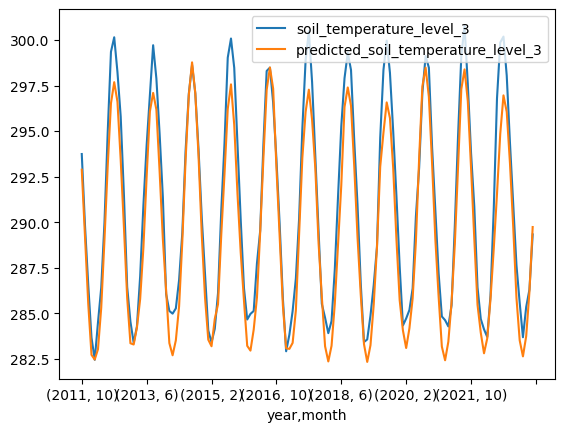

In [10]:
y_df_plot[["soil_temperature_level_3", "predicted_soil_temperature_level_3"]].plot()

In [11]:
from tesi.zappai.repositories.climate_generative_model_repository import (
    ClimateGenerativeModelRepository,
)

past_climate_data_df = ClimateDataDTO.from_list_to_dataframe(
    await past_climate_data_repository.get_past_climate_data(location.id)
)
future_climate_data_df = FutureClimateDataDTO.from_list_to_dataframe(
    await future_climate_data_repository.get_future_climate_data_for_nearest_coordinates(
        longitude=location.longitude,
        latitude=location.latitude,
        start_year=1970,
        start_month=1,
    )
)

# start generating from 1 year ago
seed_data = df_test[
    (
        -12 - SEQ_LENGTH
    ) : -12
]
start_year, start_month = seed_data.index[-1]

print(f"start_year: {start_year}")
print(f"start_month: {start_month}")

filtered_future_climate_data_df = future_climate_data_df[
    (future_climate_data_df.index.get_level_values("year") > start_year)
    | (
        (future_climate_data_df.index.get_level_values("year") == start_year)
        & (future_climate_data_df.index.get_level_values("month") > start_month)
    )
]

print(seed_data.tail().index)
print(filtered_future_climate_data_df.head().index)

# this generated data start from one year ago
generated_data_df = climate_generative_model_repository.generate_data_from_seed(
    model=model,
    x_scaler=x_scaler,
    y_scaler=y_scaler,
    seed_data=seed_data,
    future_climate_data_df=filtered_future_climate_data_df,
)
true_data_df = df_test[-12:].copy()
generated_data_df

start_year: 2023
start_month: 5
MultiIndex([(2023, 1),
            (2023, 2),
            (2023, 3),
            (2023, 4),
            (2023, 5)],
           names=['year', 'month'])
MultiIndex([(2023,  6),
            (2023,  7),
            (2023,  8),
            (2023,  9),
            (2023, 10)],
           names=['year', 'month'])
current_step.soil_temperature_level_3: [296.78988161 299.86009459 300.18246565 298.04861421 294.35320465
 291.03150576 287.64830359 285.57204633 283.68994141 285.35157267
 286.30278881 289.33208646]
enriched_prediction.soil_temperature_level_3: 291.5555114746094
current_step.soil_temperature_level_3: [299.86009459 300.18246565 298.04861421 294.35320465 291.03150576
 287.64830359 285.57204633 283.68994141 285.35157267 286.30278881
 289.33208646 291.55551147]
enriched_prediction.soil_temperature_level_3: 288.5607604980469
current_step.soil_temperature_level_3: [300.18246565 298.04861421 294.35320465 291.03150576 287.64830359
 285.57204633 283.68994141 2

soil_temperature_level_3      sin_year      cos_year  \
year month                                                         
2023 6                    291.555511  5.000000e-01 -8.660254e-01   
     7                    288.560760  1.224647e-16 -1.000000e+00   
     8                    287.630249 -5.000000e-01 -8.660254e-01   
     9                    287.018646 -8.660254e-01 -5.000000e-01   
     10                   287.408783 -1.000000e+00 -1.836970e-16   
...                              ...           ...           ...   
2030 8                    285.382721 -5.000000e-01 -8.660254e-01   
     9                    285.592560 -8.660254e-01 -5.000000e-01   
     10                   285.827667 -1.000000e+00 -1.836970e-16   
     11                   285.817841 -8.660254e-01  5.000000e-01   
     12                   285.895966 -5.000000e-01  8.660254e-01   

            10m_u_component_of_wind  10m_v_component_of_wind  2m_temperature  \
year month                                                                     
2023 6                     1.328095                -0.164694      295.286011   
     7                     1.392618                -0.207230      298.977356   
     8                     1.923957                -0.591260      297.916168   
     9                     0.766852                 0.819459      295.165894   
     10                    1.307563                 0.186940      291.823975   
...                             ...                      ...             ...   
2030 8                     1.107044                -0.781245      299.243408   
     9                     0.482181                 0.416371      296.348724   
     10                   -1.249970                -0.213915      290.473022   
     11                    0.131649                 1.207045      289.518951   
     12                    0.451253                 1.192733      284.884491   

            evaporation  total_precipitation  surface_pressure  \
year month                                                       
2023 6         0.000018             0.001450     100655.445312   
     7         0.000016             0.000741     100773.062500   
     8         0.000026             0.000441     100753.054688   
     9         0.000025             0.001364     101160.867188   
     10        0.000021             0.000081     101743.703125   
...                 ...                  ...               ...   
2030 8         0.000018             0.000467     100818.234375   
     9         0.000027             0.001705     100869.968750   
     10        0.000030             0.001701     101717.937500   
     11        0.000018             0.000486     101764.984375   
     12        0.000029             0.001829     101557.671875   

            surface_solar_radiation_downwards  \
year month                                      
2023 6                             303.487854   
     7                             295.962250   
     8                             286.247498   
     9                             208.895447   
     10                            168.237869   
...                                       ...   
2030 8                             284.366058   
     9                             204.041550   
     10                            130.768356   
     11                            103.051598   
     12                             72.347061   

            surface_thermal_radiation_downwards  
year month                                       
2023 6                               360.444244  
     7                               380.044342  
     8                               368.630371  
     9                               361.240997  
     10                              337.350433  
...                                         ...  
2030 8                               377.208618  
     9                               365.671844  
     10                              347.329193  
     11                              32

In [12]:
from matplotlib import pyplot as plt

def plot_values(df: pd.DataFrame, values: list[str]):
    df_reset = df.reset_index()
    df_reset["YYYY-MM"] = (
        df_reset["year"].astype(str) + "-" + df_reset["month"].astype(str).str.zfill(2)
    )
    df_reset.plot(
        x="YYYY-MM",
        y=values,
        marker="o",
    )
    plt.xlabel("Month")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

/tmp/ipykernel_80900/655238447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_data_df["actual_soil_temperature_level_3"] = true_data_df["soil_temperature_level_3"]
/tmp/ipykernel_80900/655238447.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_data_df["soil_temperature_level_3"] = generated_data_df["soil_temperature_level_3"] - 273.15
/tmp/ipykernel_80900/655238447.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

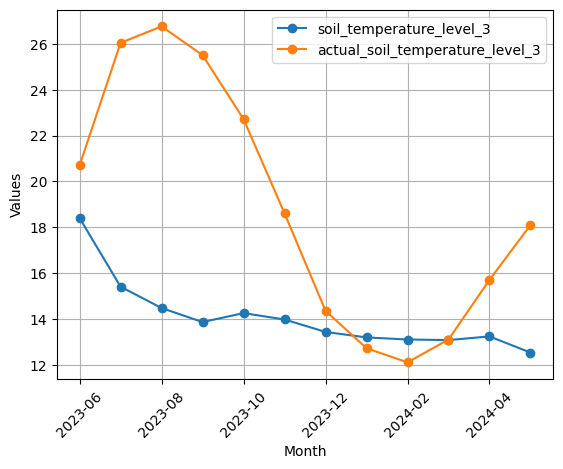

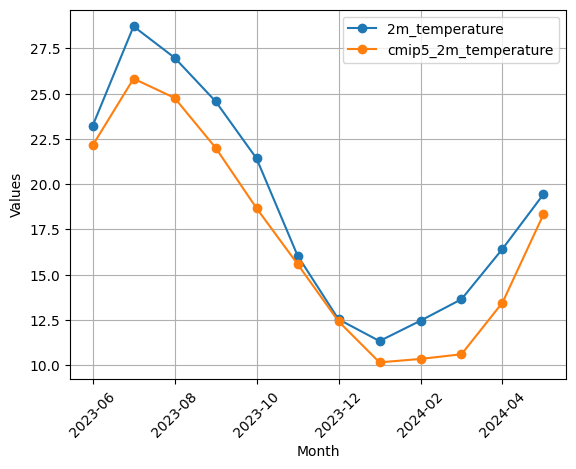

In [13]:
generated_data_df = generated_data_df[:12]
generated_data_df["actual_soil_temperature_level_3"] = true_data_df["soil_temperature_level_3"]
true_data_df["cmip5_2m_temperature"] = filtered_future_climate_data_df[:12]["2m_temperature"]

generated_data_df["soil_temperature_level_3"] = generated_data_df["soil_temperature_level_3"] - 273.15
generated_data_df["actual_soil_temperature_level_3"] = generated_data_df["actual_soil_temperature_level_3"] - 273.15

true_data_df["cmip5_2m_temperature"] = true_data_df["cmip5_2m_temperature"] - 273.15
true_data_df["2m_temperature"] = true_data_df["2m_temperature"] - 273.15

plot_values(df=generated_data_df, values=["soil_temperature_level_3", "actual_soil_temperature_level_3"])
plot_values(df=true_data_df, values=["2m_temperature", "cmip5_2m_temperature"])